# Figure 1: Comparison to published models

**Description:** Classification and cleavage deep learning model can accurately predict the location of polyA sites genome-wide and the cleavage probabilities surrounding them. Additionally, the development of a sequence strength models helps discriminate strong and weak sites.

&rarr; Run this notebook with the `tf-train` kernel


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
import utilities
from utilities import classification_cleavage, relative_strength, sequence, model_builder, genomic_context, genetics


In [5]:
## specify working directories

PROJECT = "/projects/b1080/eks/polyadenylation"
DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_01")
os.makedirs(OUTDIR, exist_ok = True)


In [6]:
palette = {
    'PolyaID'         : '#5c9bd3',
    'PolyaStrength'   : '#adcce7',
    'DeepPASTA'       : '#ec7e30',
    'APARENT'         : '#a5a4a4',
    'APARENT2'        : '#fec010',
    'PolyApredictors' : '#4971b8',
}

## IMPORT DATA

In [7]:
with open(os.path.join(DATADIR, "comprehensive_predictions", "polyaid_test_data.processed.pickle"), mode = "rb") as handle:
    polyaid_test_data = pickle.load(handle)

with open(os.path.join(DATADIR, "comprehensive_predictions", "polyastrength_test_data.processed.pickle"), mode = "rb") as handle:
    polyastrength_test_data = pickle.load(handle)
    
with open(os.path.join(DATADIR, "comprehensive_predictions", "polyastrength_pairs.processed.pickle"), mode = "rb") as handle:
    polyastrength_pairs_data = pickle.load(handle)
    
with open(os.path.join(RESDIR, "polyastrength_pairs.wide.pickle"), mode = "rb") as handle:
    polyastrength_pairs_wide = pickle.load(handle)
    
with open(os.path.join(DATADIR, "comprehensive_predictions", "APADB_v2.processed.pickle"), mode = "rb") as handle:
    apadb_data = pickle.load(handle)
    
with open(os.path.join(DATADIR, "comprehensive_predictions", "APADB_v2_shifted.processed.pickle"), mode = "rb") as handle:
    apadb_shifted_data = pickle.load(handle)
    
with open(os.path.join(DATADIR, "comprehensive_predictions", "PolyA_DB_v3.2.processed.pickle"), mode = "rb") as handle:
    polyadb_data = pickle.load(handle)
    
with open(os.path.join(DATADIR, "comprehensive_predictions", "PolyA_DB_v3.2_shifted.processed.pickle"), mode = "rb") as handle:
    polyadb_shifted_data = pickle.load(handle)
    

In [8]:
with open(os.path.join(RESDIR, "reads3_cluster_usage.pickle"), mode = 'rb') as handle:
    ru_dict = pickle.load(handle)
    
polyaid_test_data['representative'] = polyaid_test_data.apply(lambda row : ru_dict.get(row['cluster'], {}).get('position', -1) == row['start'], axis = 1)

polyaid_test_data.loc[(polyaid_test_data['representative'] == True),  'representative'] = 'representative'
polyaid_test_data.loc[(polyaid_test_data['representative'] == False), 'representative'] = 'adjacent'
polyaid_test_data.loc[(polyaid_test_data['supporting_reads'] == 0),   'representative'] = 'negative'


In [9]:
cond1 = ~polyaid_test_data['our-models_mcp-raw'].isna()
cond2 = ~polyaid_test_data['aparent_mcp-raw'].isna()
cond3 = ~polyaid_test_data['aparent-resnet_mcp-raw'].isna()
cond4 = ~polyaid_test_data['polyapredictors_mcp-raw'].isna()

polyaid_test_filt = polyaid_test_data.loc[~polyaid_test_data['sequence'].str.contains("N") & cond1 & cond2 & cond3 & cond4].copy()
print(polyaid_test_data.shape)
print(polyaid_test_filt.shape)


(210225, 39)
(159087, 39)


In [10]:
cond1 = (polyaid_test_filt['predclass'] == 'True Positive')
cond2 = (polyaid_test_filt['our-models_classification'] > 0.5)

polyaid_posdata = polyaid_test_filt.loc[cond1 & cond2].copy()

print(polyaid_test_data.shape)
print(polyaid_posdata.shape)


(210225, 39)
(90874, 39)


In [11]:
print("\nTest data:\n", polyaid_test_data['representative'].value_counts())
print("\nTest filt:\n", polyaid_test_filt['representative'].value_counts())
print("\nCenter cleavage positive data:\n", polyaid_posdata['representative'].value_counts())



Test data:
 negative          108548
adjacent           99692
representative      1985
Name: representative, dtype: int64

Test filt:
 adjacent          97817
negative          59323
representative     1947
Name: representative, dtype: int64

Center cleavage positive data:
 adjacent          89092
representative     1782
Name: representative, dtype: int64


## PolyaID test set comparison

### Site identification overall and by signal

In [12]:
class_vars = ['our-models_classification','deeppasta_classification','aparent_isoformAbundance', 'aparent-resnet_isoformAbundance','polyapredictors_expression']
class_labs = ['PolyaID','DeepPASTA','APARENT','APARENT2','PolyApredictors']


#### Representative sites

In [13]:
polyaid_repr_pos = polyaid_test_filt.loc[polyaid_test_filt['representative'] == 'representative']

polyaid_repr_pos_aataaa  = polyaid_repr_pos.loc[polyaid_repr_pos['signal_pas'] == 'AATAAA']
polyaid_repr_pos_attaaa  = polyaid_repr_pos.loc[polyaid_repr_pos['signal_pas'] == 'ATTAAA']
polyaid_repr_pos_variant = polyaid_repr_pos.loc[polyaid_repr_pos['signal_pas'].isin(['Variant','Other'])]

polyaid_repr_neg_all     = polyaid_test_filt.loc[polyaid_test_filt['representative'] == 'negative'].sample(n = len(polyaid_repr_pos),         replace = False, random_state = 1234)
polyaid_repr_neg_aataaa  = polyaid_test_filt.loc[polyaid_test_filt['representative'] == 'negative'].sample(n = len(polyaid_repr_pos_aataaa),  replace = False, random_state = 1234)
polyaid_repr_neg_attaaa  = polyaid_test_filt.loc[polyaid_test_filt['representative'] == 'negative'].sample(n = len(polyaid_repr_pos_attaaa),  replace = False, random_state = 1234)
polyaid_repr_neg_variant = polyaid_test_filt.loc[polyaid_test_filt['representative'] == 'negative'].sample(n = len(polyaid_repr_pos_variant), replace = False, random_state = 1234)

polyaid_repr_all     = pd.concat([polyaid_repr_pos,         polyaid_repr_neg_all],     ignore_index = True, sort = False)
polyaid_repr_aataaa  = pd.concat([polyaid_repr_pos_aataaa,  polyaid_repr_neg_aataaa],  ignore_index = True, sort = False)
polyaid_repr_attaaa  = pd.concat([polyaid_repr_pos_attaaa,  polyaid_repr_neg_attaaa],  ignore_index = True, sort = False)
polyaid_repr_variant = pd.concat([polyaid_repr_pos_variant, polyaid_repr_neg_variant], ignore_index = True, sort = False)

print(polyaid_test_filt.shape)
print(polyaid_repr_all.shape)
print(polyaid_repr_aataaa.shape)
print(polyaid_repr_attaaa.shape)
print(polyaid_repr_variant.shape)


(159087, 39)
(3894, 39)
(2380, 39)
(632, 39)
(882, 39)


In [14]:
class_mods   = []
class_sign   = []
class_aurocs = []
class_auprcs = []

for signal,sdata in zip(['All sites','AAUAAA','AUUAAA','Variant'], [polyaid_repr_all, polyaid_repr_aataaa, polyaid_repr_attaaa, polyaid_repr_variant]):
    for var,lab in zip(class_vars,class_labs):
        
        auroc, auprc = classification_cleavage.calculate_auc(sdata['binary_score'], sdata[var])

        class_mods.append(lab)
        class_sign.append(signal)
        class_aurocs.append(auroc)
        class_auprcs.append(auprc)

    plot_data = pd.DataFrame.from_dict({'model' : class_mods, 'signal' : class_sign, 'auroc' : class_aurocs, 'auprc' : class_auprcs})


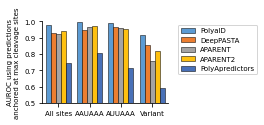

Corresponding data:
       signal            model     auroc
0   All sites          PolyaID  0.977517
1   All sites        DeepPASTA  0.928419
2   All sites          APARENT  0.923664
3   All sites         APARENT2  0.941392
4   All sites  PolyApredictors  0.744018
5      AAUAAA          PolyaID  0.998578
6      AAUAAA        DeepPASTA  0.946714
7      AAUAAA          APARENT  0.965000
8      AAUAAA         APARENT2  0.973062
9      AAUAAA  PolyApredictors  0.803810
10     AUUAAA          PolyaID  0.988493
11     AUUAAA        DeepPASTA  0.962546
12     AUUAAA          APARENT  0.958891
13     AUUAAA         APARENT2  0.951460
14     AUUAAA  PolyApredictors  0.711374
15    Variant          PolyaID  0.915406
16    Variant        DeepPASTA  0.856428
17    Variant          APARENT  0.758629
18    Variant         APARENT2  0.817828
19    Variant  PolyApredictors  0.588099


In [15]:
fig,ax = plt.subplots(1,1, figsize = (2.25,1.5))

sns.barplot(data = plot_data, x = 'signal', y = 'auroc', 
            hue = 'model', palette = palette,
            edgecolor = 'black', linewidth = 0.5, 
            saturation = 1, ax = ax)

ax.axhline(y = 0, linewidth = 0.5, color = 'black')

ax.set_xlabel("")
ax.set_ylabel("AUROC using predictions\nanchored at max cleavage sites")

ax.set_ylim(0.5,1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(bbox_to_anchor = (1.05,1))

plt.savefig(os.path.join(OUTDIR, 'benchmark_testset.classification_by_pas_signal.ctr_auroc_barplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
print(plot_data[['signal','model','auroc']])
    

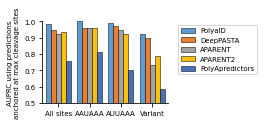

Corresponding data:
       signal            model     auprc
0   All sites          PolyaID  0.982233
1   All sites        DeepPASTA  0.949143
2   All sites          APARENT  0.923576
3   All sites         APARENT2  0.934055
4   All sites  PolyApredictors  0.754915
5      AAUAAA          PolyaID  0.999107
6      AAUAAA        DeepPASTA  0.961318
7      AAUAAA          APARENT  0.957351
8      AAUAAA         APARENT2  0.958363
9      AAUAAA  PolyApredictors  0.813672
10     AUUAAA          PolyaID  0.990627
11     AUUAAA        DeepPASTA  0.972886
12     AUUAAA          APARENT  0.944462
13     AUUAAA         APARENT2  0.924191
14     AUUAAA  PolyApredictors  0.701425
15    Variant          PolyaID  0.922834
16    Variant        DeepPASTA  0.894571
17    Variant          APARENT  0.731594
18    Variant         APARENT2  0.789645
19    Variant  PolyApredictors  0.587086


In [16]:
fig,ax = plt.subplots(1,1, figsize = (2.25,1.5))

sns.barplot(data = plot_data, x = 'signal', y = 'auprc', 
            hue = 'model', palette = palette,
            edgecolor = 'black', linewidth = 0.5, 
            saturation = 1, ax = ax)

ax.axhline(y = 0, linewidth = 0.5, color = 'black')

ax.set_xlabel("")
ax.set_ylabel("AUPRC using predictions\nanchored at max cleavage sites")

ax.set_ylim(0.5,1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(bbox_to_anchor = (1.05,1))

plt.savefig(os.path.join(OUTDIR, 'benchmark_testset.classification_by_pas_signal.ctr_auprc_barplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
print(plot_data[['signal','model','auprc']])


#### Off center predictions

In [17]:
polyaid_off_pos = polyaid_test_filt.loc[polyaid_test_filt['representative'] == 'adjacent']

polyaid_off_pos_all     = polyaid_off_pos.sample(n = 10000, replace = False, random_state = 1234)
polyaid_off_pos_aataaa  = polyaid_off_pos.loc[polyaid_off_pos['signal_pas'] == 'AATAAA'].sample(n = 10000, replace = False, random_state = 1234)
polyaid_off_pos_attaaa  = polyaid_off_pos.loc[polyaid_off_pos['signal_pas'] == 'ATTAAA'].sample(n = 10000, replace = False, random_state = 1234)
polyaid_off_pos_variant = polyaid_off_pos.loc[polyaid_off_pos['signal_pas'].isin(['Variant','Other'])].sample(n = 10000, replace = False, random_state = 1234)

polyaid_off_neg_all     = polyaid_test_filt.loc[polyaid_test_filt['representative'] == 'negative'].sample(n = len(polyaid_off_pos_all),     replace = False, random_state = 1234)
polyaid_off_neg_aataaa  = polyaid_test_filt.loc[polyaid_test_filt['representative'] == 'negative'].sample(n = len(polyaid_off_pos_aataaa),  replace = False, random_state = 1234)
polyaid_off_neg_attaaa  = polyaid_test_filt.loc[polyaid_test_filt['representative'] == 'negative'].sample(n = len(polyaid_off_pos_attaaa),  replace = False, random_state = 1234)
polyaid_off_neg_variant = polyaid_test_filt.loc[polyaid_test_filt['representative'] == 'negative'].sample(n = len(polyaid_off_pos_variant), replace = False, random_state = 1234)

polyaid_off_all     = pd.concat([polyaid_off_pos_all,     polyaid_off_neg_all],     ignore_index = True, sort = False)
polyaid_off_aataaa  = pd.concat([polyaid_off_pos_aataaa,  polyaid_off_neg_aataaa],  ignore_index = True, sort = False)
polyaid_off_attaaa  = pd.concat([polyaid_off_pos_attaaa,  polyaid_off_neg_attaaa],  ignore_index = True, sort = False)
polyaid_off_variant = pd.concat([polyaid_off_pos_variant, polyaid_off_neg_variant], ignore_index = True, sort = False)

print(polyaid_test_filt.shape)
print(polyaid_off_all.shape)
print(polyaid_off_aataaa.shape)
print(polyaid_off_attaaa.shape)
print(polyaid_off_variant.shape)


(159087, 39)
(20000, 39)
(20000, 39)
(20000, 39)
(20000, 39)


In [18]:
class_mods   = []
class_sign   = []
class_aurocs = []
class_auprcs = []

for (signal,sdata) in zip(['All sites','AAUAAA','AUUAAA','Variant'], [polyaid_off_all, polyaid_off_aataaa, polyaid_off_attaaa, polyaid_off_variant]):
    for var,lab in zip(class_vars,class_labs):
        
        auroc, auprc = classification_cleavage.calculate_auc(sdata['binary_score'], sdata[var])

        class_mods.append(lab)
        class_sign.append(signal)
        class_aurocs.append(auroc)
        class_auprcs.append(auprc)

    plot_data = pd.DataFrame.from_dict({'model' : class_mods, 'signal' : class_sign, 'auroc' : class_aurocs, 'auprc' : class_auprcs})


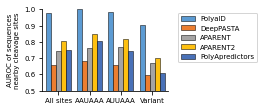

Corresponding data:
       signal            model     auroc
0   All sites          PolyaID  0.975055
1   All sites        DeepPASTA  0.656666
2   All sites          APARENT  0.744886
3   All sites         APARENT2  0.808161
4   All sites  PolyApredictors  0.749977
5      AAUAAA          PolyaID  0.999388
6      AAUAAA        DeepPASTA  0.680486
7      AAUAAA          APARENT  0.765459
8      AAUAAA         APARENT2  0.849554
9      AAUAAA  PolyApredictors  0.806336
10     AUUAAA          PolyaID  0.984787
11     AUUAAA        DeepPASTA  0.657588
12     AUUAAA          APARENT  0.770233
13     AUUAAA         APARENT2  0.817388
14     AUUAAA  PolyApredictors  0.746620
15    Variant          PolyaID  0.904657
16    Variant        DeepPASTA  0.598633
17    Variant          APARENT  0.671968
18    Variant         APARENT2  0.703505
19    Variant  PolyApredictors  0.608517


In [19]:
fig,ax = plt.subplots(1,1, figsize = (2.25,1.5))

sns.barplot(data = plot_data, x = 'signal', y = 'auroc', 
            hue = 'model', palette = palette,
            edgecolor = 'black', linewidth = 0.5, 
            saturation = 1, ax = ax)

ax.axhline(y = 0, linewidth = 0.5, color = 'black')

ax.set_xlabel("")
ax.set_ylabel("AUROC of sequences\nnearby cleavage sites")

ax.set_ylim(0.5,1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(bbox_to_anchor = (1.05,1))

plt.savefig(os.path.join(OUTDIR, 'benchmark_testset.classification_by_pas_signal.off_auroc_barplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
print(plot_data[['signal','model','auroc']])
    

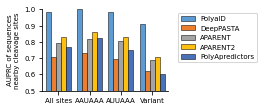

Corresponding data:
       signal            model     auprc
0   All sites          PolyaID  0.980231
1   All sites        DeepPASTA  0.704292
2   All sites          APARENT  0.794156
3   All sites         APARENT2  0.827373
4   All sites  PolyApredictors  0.768506
5      AAUAAA          PolyaID  0.999408
6      AAUAAA        DeepPASTA  0.730827
7      AAUAAA          APARENT  0.817489
8      AAUAAA         APARENT2  0.862948
9      AAUAAA  PolyApredictors  0.822063
10     AUUAAA          PolyaID  0.983481
11     AUUAAA        DeepPASTA  0.695988
12     AUUAAA          APARENT  0.808330
13     AUUAAA         APARENT2  0.828163
14     AUUAAA  PolyApredictors  0.747864
15    Variant          PolyaID  0.908621
16    Variant        DeepPASTA  0.624099
17    Variant          APARENT  0.687365
18    Variant         APARENT2  0.705557
19    Variant  PolyApredictors  0.600162


In [20]:
fig,ax = plt.subplots(1,1, figsize = (2.25,1.5))

sns.barplot(data = plot_data, x = 'signal', y = 'auprc', 
            hue = 'model', palette = palette,
            edgecolor = 'black', linewidth = 0.5, 
            saturation = 1, ax = ax)

ax.axhline(y = 0, linewidth = 0.5, color = 'black')

ax.set_xlabel("")
ax.set_ylabel("AUPRC of sequences\nnearby cleavage sites")

ax.set_ylim(0.5,1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(bbox_to_anchor = (1.05,1))

plt.savefig(os.path.join(OUTDIR, 'benchmark_testset.classification_by_pas_signal.off_auprc_barplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
print(plot_data[['signal','model','auprc']])


### Correlation between observed and predicted mean cleavage position

In [21]:
mcp_vars = ['our-models_mcp-raw', 'aparent_mcp-raw', 'aparent-resnet_mcp-raw', 'polyapredictors_mcp-raw']
mcp_labs = ['PolyaID','APARENT','APARENT2','PolyApredictors']

xs = np.arange(-25,25,1)
polyaid_posdata['scorevec_mcp'] = polyaid_posdata['scorevec'].apply(lambda y : np.dot(xs, y/np.sum(y)))


In [22]:
polyaid_mcp_all     = polyaid_posdata
polyaid_mcp_aataaa  = polyaid_posdata.loc[polyaid_posdata['signal_pas'] == 'AATAAA']
polyaid_mcp_attaaa  = polyaid_posdata.loc[polyaid_posdata['signal_pas'] == 'ATTAAA']
polyaid_mcp_variant = polyaid_posdata.loc[polyaid_posdata['signal_pas'].isin(['Variant','Other'])]

print(polyaid_test_filt.shape)
print(polyaid_mcp_all.shape)
print(polyaid_mcp_aataaa.shape)
print(polyaid_mcp_attaaa.shape)
print(polyaid_mcp_variant.shape)


(159087, 39)
(90874, 40)
(60433, 40)
(16221, 40)
(14220, 40)


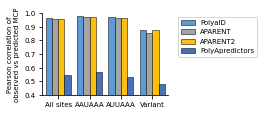

Corresponding data:
       signal            model      corr
0   All sites          PolyaID  0.963150
1   All sites          APARENT  0.957374
2   All sites         APARENT2  0.954179
3   All sites  PolyApredictors  0.548148
4      AAUAAA          PolyaID  0.979863
5      AAUAAA          APARENT  0.975634
6      AAUAAA         APARENT2  0.969371
7      AAUAAA  PolyApredictors  0.570251
8      AUUAAA          PolyaID  0.973911
9      AUUAAA          APARENT  0.968384
10     AUUAAA         APARENT2  0.963494
11     AUUAAA  PolyApredictors  0.530465
12    Variant          PolyaID  0.875556
13    Variant          APARENT  0.855667
14    Variant         APARENT2  0.874194
15    Variant  PolyApredictors  0.477324


In [23]:
mcp_mods = []
mcp_sign = []
mcp_corr = []

for (signal,sdata) in zip(['All sites','AAUAAA','AUUAAA','Variant'], [polyaid_mcp_all, polyaid_mcp_aataaa, polyaid_mcp_attaaa, polyaid_mcp_variant]):
    for var,lab in zip(mcp_vars,mcp_labs):
        
        mcp_mods.append(lab)
        mcp_sign.append(signal)
        mcp_corr.append(st.pearsonr(sdata['scorevec_mcp'], sdata[var])[0])
        
        
fig,ax = plt.subplots(1,1, figsize = (2.25,1.5))

plot_data = pd.DataFrame.from_dict({'model' : mcp_mods, 'signal' : mcp_sign, 'corr' : mcp_corr})

sns.barplot(data = plot_data, x = 'signal', y = 'corr', 
            hue = 'model', palette = palette,
            edgecolor = 'black', linewidth = 0.5, 
            saturation = 1, ax = ax)

ax.axhline(y = 0, linewidth = 0.5, color = 'black')

ax.set_xlabel("")
ax.set_ylabel("Pearson correlation of\nobserved vs predicted MCP")

ax.set_ylim(0.4,1)
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(bbox_to_anchor = (1.05,1))

plt.savefig(os.path.join(OUTDIR, 'benchmark_testset.mcp_by_pas_signal.corr_barplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
print(plot_data[['signal','model','corr']])
    

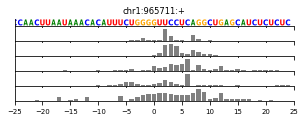

In [24]:
example_data = polyaid_posdata.loc[(polyaid_posdata['chrom'] == 'chr1') & (polyaid_posdata['start'] == 965711) & (polyaid_posdata['strand'] == '+')].iloc[0]

fig,ax = plt.subplots(6,1, figsize = (5,1.5), sharex = True, gridspec_kw = {'height_ratios' : [1,2,2,2,2,2]})

xs = np.arange(-25,25,1)
example_sequence = example_data['sequence'][95:145]
example_encoding = pd.DataFrame(genetics.encode_sequence(example_sequence), index = xs, columns = ['A','C','G','U'])

logomaker.Logo(example_encoding, ax = ax[0], width = 0.8, vpad = 0.05, color_scheme = 'classic')

ax[1].bar(xs, example_data['scorevec'], width = 0.8, color = 'gray')

ax[2].bar(xs, example_data['our-models_cleavage_norm'], width = 0.8, color = 'gray')
ax[3].bar(xs, example_data['aparent_cleavageDistribution'][78:128], width = 0.8, color = 'gray')
ax[4].bar(xs, example_data['aparent-resnet_cleavageDistribution'][78:128], width = 0.8, color = 'gray')
ax[5].bar(xs, example_data['polyapredictors_cleavage_efficiencies'][int(84-25):int(84+25)], width = 0.8, color = 'gray')

ax[5].set_xlim(-25,25)
ax[5].xaxis.set_major_locator(MultipleLocator(5))
ax[0].set_title("chr1:965711:+")

for a in ax:
    a.set_yticks([])
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'benchmark_testset.cleavage_example.chr1_965711_+.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


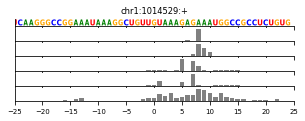

In [25]:
example_data = polyaid_posdata.loc[(polyaid_posdata['chrom'] == 'chr1') & (polyaid_posdata['start'] == 1014529) & (polyaid_posdata['strand'] == '+')].iloc[0]

fig,ax = plt.subplots(6,1, figsize = (5,1.5), sharex = True, gridspec_kw = {'height_ratios' : [1,2,2,2,2,2]})

xs = np.arange(-25,25,1)
example_sequence = example_data['sequence'][95:145]
example_encoding = pd.DataFrame(genetics.encode_sequence(example_sequence), index = xs, columns = ['A','C','G','U'])

logomaker.Logo(example_encoding, ax = ax[0], width = 0.8, vpad = 0.05, color_scheme = 'classic')

ax[1].bar(xs, example_data['scorevec'], width = 0.8, color = 'gray')

ax[2].bar(xs, example_data['our-models_cleavage_norm'], width = 0.8, color = 'gray')
ax[3].bar(xs, example_data['aparent_cleavageDistribution'][78:128], width = 0.8, color = 'gray')
ax[4].bar(xs, example_data['aparent-resnet_cleavageDistribution'][78:128], width = 0.8, color = 'gray')
ax[5].bar(xs, example_data['polyapredictors_cleavage_efficiencies'][int(84-25):int(84+25)], width = 0.8, color = 'gray')

ax[5].set_xlim(-25,25)
ax[5].xaxis.set_major_locator(MultipleLocator(5))
ax[0].set_title("chr1:1014529:+")

for a in ax:
    a.set_yticks([])
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'benchmark_testset.cleavage_example.chr1_1014529_+.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


## PolyaStrength test set comparison

In [26]:
strength_comp_vars   = ['our-models_strength','deeppasta_classification','aparent_isoformAbundance','aparent-resnet_isoformAbundance','polyapredictors_expression']
strength_comp_labs   = ['PolyaStrength','DeepPASTA','APARENT','APARENT2','PolyApredictors']


### Classification of highly vs lowly used sites (or "strong" vs "weak")

In [27]:
##

predicted_pairs_keys = {}

for i,row in polyastrength_pairs_wide.iterrows():
    predicted_pairs_keys[row['label']] = row['random_class']
    
    
predicted_pairs_results = {
    'label' : [],
    'comptype' : [],
    'random_class' : [],
    'our-models_strength' : [], 
    'deeppasta_classification' : [],
    'aparent_isoformAbundance' : [],
    'aparent-resnet_isoformAbundance' : [],
    'polyapredictors_expression' : [],
}

##

for i,row in polyastrength_pairs_data.iterrows():
    
    predicted_pairs_results['label'].append(row['label'])
    predicted_pairs_results['comptype'].append(row['comptype'])
    predicted_pairs_results['random_class'].append(predicted_pairs_keys[row['label']])
    
    for cv in strength_comp_vars:
        predicted_pairs_results[cv].append(row[cv])

predicted_pairs = pd.DataFrame.from_dict(predicted_pairs_results, orient = 'columns')
print(predicted_pairs.shape)

##

predicted_pairs_strongest = predicted_pairs.loc[predicted_pairs['comptype'] == 'strongest']
predicted_pairs_random    = predicted_pairs.loc[predicted_pairs['comptype'] == 'random']

predicted_pairs_wide = predicted_pairs_strongest.merge(predicted_pairs_random[['label'] + strength_comp_vars], 
                                                       how = 'inner', on = 'label',
                                                       suffixes = ['_strongest', '_random'])

## 

for pc in strength_comp_vars:
    
    predicted_pairs_wide.loc[predicted_pairs_wide['random_class'] == 0, f'{pc}_major'] = predicted_pairs_wide[f'{pc}_random']
    predicted_pairs_wide.loc[predicted_pairs_wide['random_class'] == 1, f'{pc}_major'] = predicted_pairs_wide[f'{pc}_strongest']

    predicted_pairs_wide.loc[predicted_pairs_wide['random_class'] == 0, f'{pc}_minor'] = predicted_pairs_wide[f'{pc}_strongest']
    predicted_pairs_wide.loc[predicted_pairs_wide['random_class'] == 1, f'{pc}_minor'] = predicted_pairs_wide[f'{pc}_random']

    predicted_pairs_wide[f'{pc}_difference'] = predicted_pairs_wide[f'{pc}_major'] - predicted_pairs_wide[f'{pc}_minor']


(16334, 8)


In [28]:
strength_comp_mods   = []
strength_comp_aurocs = []
strength_comp_auprcs = []

for (comp_var,comp_lab) in zip(strength_comp_vars,strength_comp_labs):

    auroc, auprc = classification_cleavage.calculate_auc(predicted_pairs_wide['random_class'], predicted_pairs_wide[f'{comp_var}_difference'])

    strength_comp_mods.append(comp_lab)
    strength_comp_aurocs.append(auroc)
    strength_comp_auprcs.append(auprc)
    
plot_data = pd.DataFrame.from_dict({'model' : strength_comp_mods, 'auroc' : strength_comp_aurocs, 'auprc' : strength_comp_auprcs})


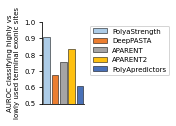

Corresponding metrics:
             model     auroc     auprc
0    PolyaStrength  0.909021  0.907763
1        DeepPASTA  0.676664  0.659969
2          APARENT  0.752664  0.745517
3         APARENT2  0.834045  0.836062
4  PolyApredictors  0.605832  0.589019


In [29]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

sns.barplot(data = plot_data, x = 'model', y = 'auroc', 
            hue = 'model', palette = palette, 
            dodge = False, edgecolor = 'black', linewidth = 0.5, 
            saturation = 1, ax = ax)

ax.axhline(y = 0, linewidth = 0.5, color = 'black')

ax.set_xticks([])
ax.set_xlabel("")

ax.set_ylim(0.5,1)
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.set_ylabel("AUROC classifying highly vs\nlowly used terminal exonic sites")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(bbox_to_anchor = (1.05,1))

plt.savefig(os.path.join(OUTDIR, 'benchmark_testset.separating_sites_by_usage_by_model.auroc_barplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding metrics:")
print(plot_data)
    

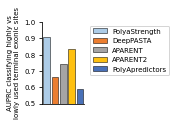

Corresponding metrics:
             model     auroc     auprc
0    PolyaStrength  0.909021  0.907763
1        DeepPASTA  0.676664  0.659969
2          APARENT  0.752664  0.745517
3         APARENT2  0.834045  0.836062
4  PolyApredictors  0.605832  0.589019


In [30]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

sns.barplot(data = plot_data, x = 'model', y = 'auprc', 
            hue = 'model', palette = palette, 
            dodge = False, edgecolor = 'black', linewidth = 0.5, 
            saturation = 1, ax = ax)

ax.axhline(y = 0, linewidth = 0.5, color = 'black')

ax.set_xticks([])
ax.set_xlabel("")

ax.set_ylim(0.5,1)
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.set_ylabel("AUPRC classifying highly vs\nlowly used terminal exonic sites")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(bbox_to_anchor = (1.05,1))

plt.savefig(os.path.join(OUTDIR, 'benchmark_testset.separating_sites_by_usage_by_model.auprc_barplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding metrics:")
print(plot_data)
    

## Benchmark database comparison

### Selecting qualifying sites based on supporting reads

In [31]:
reads_cutoff = 10
rpm_cutoff = 3

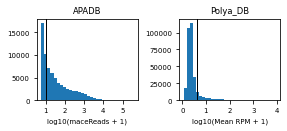

In [32]:
fig,ax = plt.subplots(1,2, figsize = (4, 2))

(np.log10(1+apadb_data['maceReads'])).hist(ax = ax[0], bins = 30, grid = False)
(np.log10(1+polyadb_data['Mean RPM'])).hist(ax = ax[1], bins = 30, grid = False)

ax[0].axvline(x = np.log10(reads_cutoff+1), color = 'black', linewidth = 1)
ax[1].axvline(x = np.log10(rpm_cutoff+1),   color = 'black', linewidth = 1)

ax[0].set_title("APADB")
ax[0].set_xlabel("log10(maceReads + 1)")
ax[0].xaxis.set_major_locator(MultipleLocator(1))

ax[1].set_title("Polya_DB")
ax[1].set_xlabel("log10(Mean RPM + 1)")
ax[1].xaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [33]:
apadb_filt = apadb_data.loc[apadb_data['maceReads'] >= reads_cutoff].copy()
print("\nAPADB:")
print(apadb_data.shape)
print(apadb_filt.shape)

apadb_shifted_filt = apadb_shifted_data.loc[apadb_shifted_data['maceReads'] >= reads_cutoff].copy()
print("\nAPADB shifted:")
print(apadb_shifted_data.shape)
print(apadb_shifted_filt.shape)

polyadb_filt = polyadb_data.loc[polyadb_data['Mean RPM'] >= rpm_cutoff].copy()
print("\nPolyaDB:")
print(polyadb_data.shape)
print(polyadb_filt.shape)

polyadb_shifted_filt = polyadb_shifted_data.loc[polyadb_shifted_data['Mean RPM'] >= rpm_cutoff].copy()
print("\nPolyaDB:")
print(polyadb_shifted_data.shape)
print(polyadb_shifted_filt.shape)



APADB:
(71829, 46)
(48860, 46)

APADB shifted:
(71829, 43)
(48860, 43)

PolyaDB:
(311594, 54)
(36701, 54)

PolyaDB:
(311594, 51)
(36701, 51)


### Site identification (classification)

In [34]:
class_vars = ['our-models_classification','deeppasta_classification','aparent_isoformAbundance', 'aparent-resnet_isoformAbundance','polyapredictors_expression']
class_labs = ['PolyaID','DeepPASTA','APARENT','APARENT2','PolyApredictors']

nc_all     = (polyaid_test_data.loc[polyaid_test_data['supporting_reads'] == 0, ['supporting_reads']+class_vars].copy())
nc_apadb   = nc_all.sample(n = len(apadb_filt),   replace = False, random_state = 1234)
nc_polyadb = nc_all.sample(n = len(polyadb_filt), replace = False, random_state = 1234)

print("APADB NCs:", nc_apadb.shape)
print("PolyaDB NCs:", nc_polyadb.shape)


APADB NCs: (48860, 6)
PolyaDB NCs: (36701, 6)


In [35]:
apadb_comb_nc = pd.concat([apadb_filt.rename(columns = {'maceReads' : 'supporting_reads'}), nc_apadb], ignore_index = True, sort = False)[['supporting_reads']+class_vars]
apadb_comb_nc['binary_class'] = (apadb_comb_nc['supporting_reads'] > 0)

apadb_shifted_comb_nc = pd.concat([apadb_shifted_filt.rename(columns = {'maceReads' : 'supporting_reads'}), nc_apadb], ignore_index = True, sort = False)[['supporting_reads']+class_vars]
apadb_shifted_comb_nc['binary_class'] = (apadb_shifted_comb_nc['supporting_reads'] > 0)

polyadb_comb_nc = pd.concat([polyadb_filt.rename(columns = {'Mean RPM' : 'supporting_reads'}), nc_polyadb], ignore_index = True, sort = False)[['supporting_reads']+class_vars]
polyadb_comb_nc['binary_class'] = (polyadb_comb_nc['supporting_reads'] > 0)

polyadb_shifted_comb_nc = pd.concat([polyadb_shifted_filt.rename(columns = {'Mean RPM' : 'supporting_reads'}), nc_polyadb], ignore_index = True, sort = False)[['supporting_reads']+class_vars]
polyadb_shifted_comb_nc['binary_class'] = (polyadb_shifted_comb_nc['supporting_reads'] > 0)


In [36]:
class_aurocs_apadb           = []
class_aurocs_apadb_shifted   = []
class_aurocs_polyadb         = []
class_aurocs_polyadb_shifted = []

class_auprcs_apadb           = []
class_auprcs_apadb_shifted   = []
class_auprcs_polyadb         = []
class_auprcs_polyadb_shifted = []

for (v,l) in zip(class_vars,class_labs):
    
    auroc, auprc = classification_cleavage.calculate_auc(apadb_comb_nc['binary_class'].ravel(), apadb_comb_nc[v].ravel())
    class_aurocs_apadb.append(auroc)
    class_auprcs_apadb.append(auprc)
    
    auroc, auprc = classification_cleavage.calculate_auc(apadb_shifted_comb_nc['binary_class'].ravel(), apadb_shifted_comb_nc[v].ravel())
    class_aurocs_apadb_shifted.append(auroc)
    class_auprcs_apadb_shifted.append(auprc)
    
    auroc, auprc = classification_cleavage.calculate_auc(polyadb_comb_nc['binary_class'].ravel(), polyadb_comb_nc[v].ravel())
    class_aurocs_polyadb.append(auroc)
    class_auprcs_polyadb.append(auprc)
    
    auroc, auprc = classification_cleavage.calculate_auc(polyadb_shifted_comb_nc['binary_class'].ravel(), polyadb_shifted_comb_nc[v].ravel())
    class_aurocs_polyadb_shifted.append(auroc)
    class_auprcs_polyadb_shifted.append(auprc)


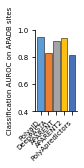

Corresponding AUROCs:
	PolyaID         0.949
	DeepPASTA       0.829
	APARENT         0.915
	APARENT2        0.940
	PolyApredictors 0.813


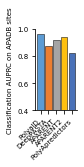

Corresponding AURPCs:
	PolyaID         0.964
	DeepPASTA       0.875
	APARENT         0.914
	APARENT2        0.937
	PolyApredictors 0.821


In [37]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

ax.bar(class_labs, class_aurocs_apadb, color = [palette.get(x) for x in class_labs], edgecolor = 'black', linewidth = 0.5)

ax.set_xticks(np.arange(len(class_labs)))
ax.set_xticklabels(class_labs, rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(0.4,1)
ax.set_ylabel("Classification AUROC on APADB sites")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'benchmark_databases.apadb_class.auroc_barplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()

print("Corresponding AUROCs:")
for m,a in zip(class_labs, class_aurocs_apadb):
    print(f"\t{m:15} {a:.03f}")


    
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

ax.bar(class_labs, class_auprcs_apadb, color = [palette.get(x) for x in class_labs], edgecolor = 'black', linewidth = 0.5)

ax.set_xticks(np.arange(len(class_labs)))
ax.set_xticklabels(class_labs, rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(0.4,1)
ax.set_ylabel("Classification AUPRC on APADB sites")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'benchmark_databases.apadb_class.auprc_barplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()

print("Corresponding AURPCs:")
for m,a in zip(class_labs, class_auprcs_apadb):
    print(f"\t{m:15} {a:.03f}")


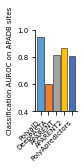

Corresponding AUROCs:
	PolyaID         0.946
	DeepPASTA       0.604
	APARENT         0.811
	APARENT2        0.866
	PolyApredictors 0.810


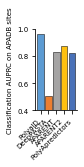

Corresponding AUPRCs:
	PolyaID         0.962
	DeepPASTA       0.508
	APARENT         0.832
	APARENT2        0.873
	PolyApredictors 0.823


In [38]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

ax.bar(class_labs, class_aurocs_apadb_shifted, color = [palette.get(x) for x in class_labs], edgecolor = 'black', linewidth = 0.5)

ax.set_xticks(np.arange(len(class_labs)))
ax.set_xticklabels(class_labs, rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(0.4,1)
ax.set_ylabel("Classification AUROC on APADB sites")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'benchmark_databases.apadb_class.auroc_barplot.adjacent.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()

print("Corresponding AUROCs:")
for m,a in zip(class_labs, class_aurocs_apadb_shifted):
    print(f"\t{m:15} {a:.03f}")


    
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

ax.bar(class_labs, class_auprcs_apadb_shifted, color = [palette.get(x) for x in class_labs], edgecolor = 'black', linewidth = 0.5)

ax.set_xticks(np.arange(len(class_labs)))
ax.set_xticklabels(class_labs, rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(0.4,1)
ax.set_ylabel("Classification AUPRC on APADB sites")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'benchmark_databases.apadb_class.auprc_barplot.adjacent.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()

print("Corresponding AUPRCs:")
for m,a in zip(class_labs, class_auprcs_apadb_shifted):
    print(f"\t{m:15} {a:.03f}")


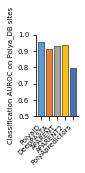

Corresponding AUROCs:
	PolyaID         0.956
	DeepPASTA       0.914
	APARENT         0.930
	APARENT2        0.935
	PolyApredictors 0.794


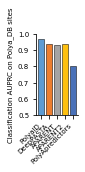

Corresponding AUPRCs:
	PolyaID         0.969
	DeepPASTA       0.935
	APARENT         0.932
	APARENT2        0.938
	PolyApredictors 0.801


In [39]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

ax.bar(class_labs, class_aurocs_polyadb, color = [palette.get(x) for x in class_labs], edgecolor = 'black', linewidth = 0.5)

ax.set_xticks(np.arange(len(class_labs)))
ax.set_xticklabels(class_labs, rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(0.5,1)
ax.set_ylabel("Classification AUROC on Polya_DB sites")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'benchmark_databases.polyadb_class.auroc_barplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()

print("Corresponding AUROCs:")
for m,a in zip(class_labs, class_aurocs_polyadb):
    print(f"\t{m:15} {a:.03f}")

    
    
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

ax.bar(class_labs, class_auprcs_polyadb, color = [palette.get(x) for x in class_labs], edgecolor = 'black', linewidth = 0.5)

ax.set_xticks(np.arange(len(class_labs)))
ax.set_xticklabels(class_labs, rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(0.5,1)
ax.set_ylabel("Classification AUPRC on Polya_DB sites")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'benchmark_databases.polyadb_class.auprc_barplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()

print("Corresponding AUPRCs:")
for m,a in zip(class_labs, class_auprcs_polyadb):
    print(f"\t{m:15} {a:.03f}")


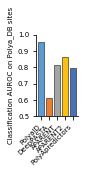

Corresponding AUROCs:
	PolyaID         0.955
	DeepPASTA       0.609
	APARENT         0.816
	APARENT2        0.861
	PolyApredictors 0.796


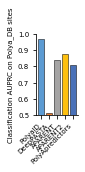

Corresponding AUPRCs:
	PolyaID         0.968
	DeepPASTA       0.511
	APARENT         0.839
	APARENT2        0.877
	PolyApredictors 0.809


In [40]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

ax.bar(class_labs, class_aurocs_polyadb_shifted, color = [palette.get(x) for x in class_labs], edgecolor = 'black', linewidth = 0.5)

ax.set_xticks(np.arange(len(class_labs)))
ax.set_xticklabels(class_labs, rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(0.5,1)
ax.set_ylabel("Classification AUROC on Polya_DB sites")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'benchmark_databases.polyadb_class.auroc_barplot.adjacent.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()

print("Corresponding AUROCs:")
for m,a in zip(class_labs, class_aurocs_polyadb_shifted):
    print(f"\t{m:15} {a:.03f}")

    
    
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

ax.bar(class_labs, class_auprcs_polyadb_shifted, color = [palette.get(x) for x in class_labs], edgecolor = 'black', linewidth = 0.5)

ax.set_xticks(np.arange(len(class_labs)))
ax.set_xticklabels(class_labs, rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(0.5,1)
ax.set_ylabel("Classification AUPRC on Polya_DB sites")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'benchmark_databases.polyadb_class.auprc_barplot.adjacent.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()

print("Corresponding AUPRCs:")
for m,a in zip(class_labs, class_auprcs_polyadb_shifted):
    print(f"\t{m:15} {a:.03f}")


### Classification of highly vs lowly used sites (or "strong" vs "weak")

In [41]:
with open(os.path.join(RESDIR, 'apadb_pairs.wide.pickle'), mode = 'rb') as handle:
    pairs_apadb = pickle.load(handle)

with open(os.path.join(RESDIR, 'polyadb_pairs.wide.pickle'), mode = 'rb') as handle:
    pairs_polyadb = pickle.load(handle)

print("APADB pairs:", len(pairs_apadb))
print("PolyA_DB pairs:", len(pairs_polyadb))


APADB pairs: 5023
PolyA_DB pairs: 4217


In [42]:
strength_vars = ['our-models_strength','deeppasta_classification','aparent_isoformAbundance','aparent-resnet_isoformAbundance','polyapredictors_expression']
strength_labs = ['PolyaStrength','DeepPASTA','APARENT','APARENT2','PolyApredictors']

strength_aurocs_apadb   = []
strength_auprcs_apadb   = []
strength_aurocs_polyadb = []
strength_auprcs_polyadb = []

for (v,l) in zip(strength_vars,strength_labs):

    pairs_apadb[f'rd_{l}'] = 0
    pairs_apadb.loc[pairs_apadb['random_class'] == 0, f'rd_{l}'] = pairs_apadb[f'{v}_mix'] - pairs_apadb[f'{v}_max']
    pairs_apadb.loc[pairs_apadb['random_class'] == 1, f'rd_{l}'] = pairs_apadb[f'{v}_max'] - pairs_apadb[f'{v}_mix']
    
    pairs_polyadb[f'rd_{l}'] = 0
    pairs_polyadb.loc[pairs_polyadb['random_class'] == 0, f'rd_{l}'] = pairs_polyadb[f'{v}_mix'] - pairs_polyadb[f'{v}_max']
    pairs_polyadb.loc[pairs_polyadb['random_class'] == 1, f'rd_{l}'] = pairs_polyadb[f'{v}_max'] - pairs_polyadb[f'{v}_mix']
    
    auroc, auprc = classification_cleavage.calculate_auc(pairs_apadb['random_class'].ravel(), pairs_apadb[f'rd_{l}'].ravel())
    strength_aurocs_apadb.append(auroc)
    strength_auprcs_apadb.append(auprc)
    
    auroc, auprc = classification_cleavage.calculate_auc(pairs_polyadb['random_class'].ravel(), pairs_polyadb[f'rd_{l}'].ravel())
    strength_aurocs_polyadb.append(auroc)
    strength_auprcs_polyadb.append(auprc)


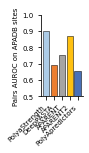

Corresponding AUROCs:
	PolyaStrength   0.901
	DeepPASTA       0.689
	APARENT         0.756
	APARENT2        0.872
	PolyApredictors 0.654


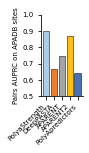

Corresponding AUPRCs:
	PolyaStrength   0.898
	DeepPASTA       0.669
	APARENT         0.749
	APARENT2        0.869
	PolyApredictors 0.642


In [43]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

ax.bar(strength_labs, strength_aurocs_apadb, color = [palette.get(x) for x in strength_labs], edgecolor = 'black', linewidth = 0.5)

ax.set_xticks(np.arange(len(strength_labs)))
ax.set_xticklabels(strength_labs, rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(0.5,1)
ax.set_ylabel("Pairs AUROC on APADB sites")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'benchmark_databases.apadb_pairs.auroc_barplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()

print("Corresponding AUROCs:")
for m,a in zip(strength_labs,strength_aurocs_apadb):
    print(f"\t{m:15} {a:.03f}")

    
    
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

ax.bar(strength_labs, strength_auprcs_apadb, color = [palette.get(x) for x in strength_labs], edgecolor = 'black', linewidth = 0.5)

ax.set_xticks(np.arange(len(strength_labs)))
ax.set_xticklabels(strength_labs, rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(0.5,1)
ax.set_ylabel("Pairs AUPRC on APADB sites")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'benchmark_databases.apadb_pairs.auprc_barplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()

print("Corresponding AUPRCs:")
for m,a in zip(strength_labs,strength_auprcs_apadb):
    print(f"\t{m:15} {a:.03f}")


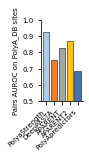

Corresponding AUROCs:
	PolyaStrength   0.923
	DeepPASTA       0.755
	APARENT         0.827
	APARENT2        0.868
	PolyApredictors 0.683


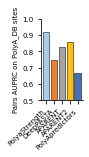

Corresponding AUPRCs:
	PolyaStrength   0.921
	DeepPASTA       0.745
	APARENT         0.825
	APARENT2        0.858
	PolyApredictors 0.666


In [44]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

ax.bar(strength_labs, strength_aurocs_polyadb, color = [palette.get(x) for x in strength_labs], edgecolor = 'black', linewidth = 0.5)

ax.set_xticks(np.arange(len(strength_labs)))
ax.set_xticklabels(strength_labs, rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(0.5,1)
ax.set_ylabel("Pairs AUROC on PolyA_DB sites")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'benchmark_databases.polyadb_pairs.auroc_barplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()

print("Corresponding AUROCs:")
for m,a in zip(strength_labs,strength_aurocs_polyadb):
    print(f"\t{m:15} {a:.03f}")

    
    
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

ax.bar(strength_labs, strength_auprcs_polyadb, color = [palette.get(x) for x in strength_labs], edgecolor = 'black', linewidth = 0.5)

ax.set_xticks(np.arange(len(strength_labs)))
ax.set_xticklabels(strength_labs, rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(0.5,1)
ax.set_ylabel("Pairs AUPRC on PolyA_DB sites")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'benchmark_databases.polyadb_pairs.auprc_barplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()

print("Corresponding AUPRCs:")
for m,a in zip(strength_labs,strength_auprcs_polyadb):
    print(f"\t{m:15} {a:.03f}")
